# 0. Overview

### Data

We will be analyzing an extract of 1994 U.S. Census data. See more on the data set [here](https://archive.ics.uci.edu/ml/datasets/census+income). First, we are going to need some help from some well-known, third-party libraries

### Goals

Work through the given data - cleaning it, exploring it, transforming it - so as to come to a point where we can build a model to predict whether or not a given citizen, based on the other available information, earns over $50K per year. Additionally, we will dive into learning the proper protocols for setting up for tuning, and evaluating, our predictive models. 

### Third-party libraries

Third-party libraries are libraries (collections of code) that do not come with the core Python distribution. You can get these libraries through downloading the Anaconda distribution, which includes them all, or through installing them manually with `pip` (or `pip3`, depending on your system), which is the Python package manager.

When importing a Python library, you can give it an alias, which is usually done to make something easier to type. It's good to follow standard protocol for a given library when doing this so that other people will recognize it throughout your code. 

`numpy` (typically abbreviated as `np`) provides the following:
- a homogenous (read: for a single data type) array with very useful manipulation methods
- a number of useful advanced math functions
- other data type helpers
- in many ways `numpy` is a collection of Python wrappers for very well-optimized C and FORTRAN math code

`pandas` (typically abbreviated as `pd`) is:
- a library that provides, amongst other things, a very nice data structure known as the `DataFrame`
- the `DataFrame` is a relational / tabular data structure
- i.e. it allows you to do SQL-ish analysis in Python
- it also visualizes nicely in Jupyter notebooks
- a good bit of Pandas is actually just user-friendly interfaces on top of `numpy`

`matplotlib` (from which the `pyplot` submodule is typically imported and aliased as `plt`)
- the old faithful data visualization library for Python
- it definitely provides a steep learning curve
- but it's a powerful tool once learned

`sklearn`
- the "gold standard" for non-neural-nets (look at `tensorflow` for those) machine learning models
- battle tested, widely uses

`seaborn`
- provides additional data visualization, particularly the "heat map"

In [1]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFE, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (
            train_test_split, cross_val_score, cross_validate, GridSearchCV,
            validation_curve
)
from sklearn.metrics import (
            accuracy_score, confusion_matrix, precision_score, recall_score,
            make_scorer, PrecisionRecallDisplay
)

### Taking notes in a `jupyter notebook`

The ability to intertermix well-formatted notes with your code and charts is one of the strongest features that `jupyer` offers its users. You can write notes with [markdown syntax](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet). Below is a an example markdown cell, which you can `enter` into to see how its formatting is created: 

**Example note taking**:
> Here is a *quote* 

We can write `code`, too:
```
def fake_func():
    return None
```

You can write math, too:
> $\sum n$

Here's a [link](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) to more examples.

### Plots

In [2]:
%matplotlib inline

The above is a _magic_ Jupyter command that ensures all `matplotlib` plots will by default show in the notebook.

# 1. Get Data

### Retrieve and quick look

In [3]:
def get_census_data():
    # column names
    cols = ['age', 'workclass', 'fnlwgt', 'education', 
            'education_num', 'marital_status', 'occupation',
            'relationship', 'race', 'sex', 'capital_gain',
            'capital_loss', 'hours_per_week', 'native_country', 
            'over_fifty_k']

    # url to retrieve data from
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'

    print("Retrieving data.")

    # convert data from of list of lists to DataFrame, set columns, and return
    return pd.read_csv(url, names=cols)

Let's use the above function to retrieve our data:

In [4]:
table = get_census_data()

Retrieving data.


A great first step is to check out the size of your data:

In [5]:
table.shape

(32561, 15)

Next, let's look at data types. We can call the `dtypes` attribute on our `DataFrame` to see the data type for each of its columns. We'll then pass those results into the `value_counts` method, which returns all the values in the column it's called on, with the number of times that each value shows up in the column:

In [6]:
table.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education_num      int64
marital_status    object
occupation        object
relationship      object
race              object
sex               object
capital_gain       int64
capital_loss       int64
hours_per_week     int64
native_country    object
over_fifty_k      object
dtype: object

In [7]:
table.dtypes.value_counts()

object    9
int64     6
dtype: int64

All data columns are currently formatted as _strings_ (which `pandas` represents with the `object` type), which we will have to handle accordingly. 

Let's actually _look_ quickly at the top and bottom of the table. We can do this through using `iloc`, which takes the _integer location_ of rows and columns to return:

In [8]:
table.iloc[:5, :7]

,age,workclass,fnlwgt,education,education_num,marital_status,occupation
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty


In [9]:
table.iloc[-5:, 8:]

,race,sex,capital_gain,capital_loss,hours_per_week,native_country,over_fifty_k
32556,White,Female,0,0,38,United-States,<=50K
32557,White,Male,0,0,40,United-States,>50K
32558,White,Female,0,0,40,United-States,<=50K
32559,White,Male,0,0,20,United-States,<=50K
32560,White,Female,15024,0,40,United-States,>50K


### Data cleanliness

Let's check for missing values:

`isnull()` is a method that returns `True` for every row in `data` that is `null`, in each of the columns. We can then call `sum` on the results to see the total number of `null` values in each column.

We see that we have 1 missing value each, for every column except for `age` - let's see if these all these values are in the same row:

In [10]:
table[table.isnull().any(1)].index

Int64Index([], dtype='int64')

One of the ways in which we can filter a `DataFrame` is to pass a condition into it using square brackets.The square bracket syntax works such that it will then return the rows in the `DataFrame` that have a value of `True`. So, `isnull` returns a whole collection of `True` or `False` values for each position in the index, and the square bracket syntax then returns the rest of the row for each `True` index value. 

Now, let's check for duplicates:

In [11]:
table.duplicated().head()

0    False
1    False
2    False
3    False
4    False
dtype: bool

In [12]:
table.duplicated().sum()

24

In [13]:
table[table.duplicated(keep=False)].sort_values(table.columns.to_list()).head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,over_fifty_k
17673,19,Private,97261,HS-grad,9,Never-married,Farming-fishing,Not-in-family,White,Male,0,0,40,United-States,<=50K
18698,19,Private,97261,HS-grad,9,Never-married,Farming-fishing,Not-in-family,White,Male,0,0,40,United-States,<=50K
6990,19,Private,138153,Some-college,10,Never-married,Adm-clerical,Own-child,White,Female,0,0,10,United-States,<=50K
21318,19,Private,138153,Some-college,10,Never-married,Adm-clerical,Own-child,White,Female,0,0,10,United-States,<=50K
15189,19,Private,146679,Some-college,10,Never-married,Exec-managerial,Own-child,Black,Male,0,0,30,United-States,<=50K


The `duplicated` method works similarly to `isnull`, in that it returns a _boolean mask_. By default, it will return `True` for a row that has _already_ been seen. You can control whether it treats the _first_ or _last_ instance of a row as a duplicate, or you can also count _all_ instances of a given row (that appears more than once) as duplicates. This behavior is controlled through the `keep` _keyword argument_. 

Let's write _all_ duplicates to file before we drop them. We can do this using the `to_csv` method, which takes (in addition to other optional parameters that control things like the delimiter used) a _path_ to write the file to:

In [14]:
table[table.duplicated(keep=False)].to_csv("duplicates.csv")

In [15]:
table = table.drop_duplicates()

### Data type handling - _numeric_

Let's get this data typed properly. We may have to manually make these changes using the `astype` method, but let's see what the `infer_objects` method can do for us:

In [16]:
table.infer_objects().dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education_num      int64
marital_status    object
occupation        object
relationship      object
race              object
sex               object
capital_gain       int64
capital_loss       int64
hours_per_week     int64
native_country    object
over_fifty_k      object
dtype: object

Great! Let's retain:

In [17]:
table = table.infer_objects()

### Data type handling - _boolean_

Let's take a closer look at what we're trying to predict - `over_fifty_k`:

In [18]:
table.over_fifty_k.head()

0     <=50K
1     <=50K
2     <=50K
3     <=50K
4     <=50K
Name: over_fifty_k, dtype: object

This doesn't look very nice, does it?

In [19]:
table.over_fifty_k.value_counts()

 <=50K    24698
 >50K      7839
Name: over_fifty_k, dtype: int64

So, this is really a `bool` variable, but we currently have it represented via this _ugly_ string. Let's fix that.

### --

### Problem

Re-engineer this as a `bool` column.

### --

### Data type handling - almost done

Let's take a look at what we've done so far:

In [23]:
table.dtypes.value_counts()

object    9
int64     6
bool      1
dtype: int64

We can actually make sub-selections on our table, by `dtype`:

In [24]:
table.select_dtypes(include=[int]).head()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
0,39,77516,13,2174,0,40
1,50,83311,13,0,0,13
2,38,215646,9,0,0,40
3,53,234721,7,0,0,40
4,28,338409,13,0,0,40


In [25]:
table.select_dtypes(exclude=[object, int]).head()

,over_fifty_k_bool
0,False
1,False
2,False
3,False
4,False


Wait... before we progress - should we check all the other `object` columns to make sure they don't have the same issue as `over_fifty_k` did?

### --

### Problem

Check whether other `object` column values have issues with trailing and / or leading spaces, and try to make use of iteration and / or group selection.

### --

# 2. Exploratory Data Analysis

Exploratory data analysis (EDA) is key to understanding your data - this is where you poke around and see how things work.

### Numeric columns - _distributional analysis_

With numeric data, we often want to understand how it's _distributed_, i.e. the frequencies associated with different values in the data.

Let's start with `age`. We can see the number of unique values with the `nunique` method:

In [31]:
table.age.nunique()

73

We have a good number of values here, but this is still _discrete_ data, so we can actually use `value_counts` to analyze it.

In the following cell, we're going to go into `table`, get the `age` column, call `value_counts`, sort the index with the `sort_index` method (so that the ages are presented in _numerical_ order, as opposed order of frequency, which is how `value_counts` will return its results) and then we're going to call `plot`.

You can call (i.e. put parantheses after the function name) `plot` directly, which will produce a _line_ plot, or you can specify other types of plots. In this case, we're calling the `bar` method, which will give us a _bar graph_. I've passed some additional arguments to `bar` to control the _size_ of the figure, as well as the _color_ of the plot, and, finally, the rotation of the _x-axis_ labels.

The results of this procedure are the _axes_ of the plot, which can be used to further modify the plot. I'm using these _axes_ (stored in the variable `ax`) to set a title.

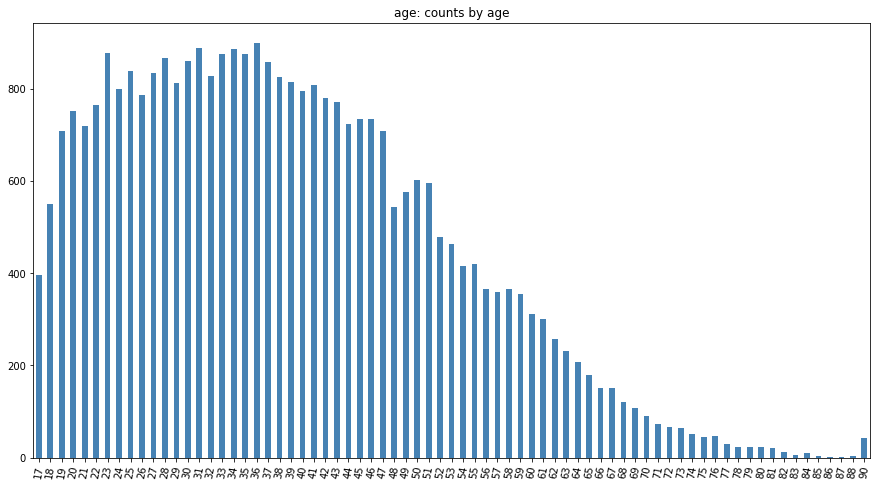

In [32]:
ax = table.age.value_counts().sort_index().plot.bar(figsize=(15, 8), color="steelblue", rot=80)
ax.title.set_text('age: counts by age')

They say a picture's worth a thousand words, and I think that adage undoubtedly holds true in data analysis.

Right off the bat, we can see here that there's an unusual spike at 90, which could indicate that all ages greater than or equal to 90 were simply bucketed. Additionally, we can that the 30s are probably the most well-represented decade in this data. 

Let's put some numbers behind these observations.

In [33]:
table.age.describe().to_frame()

,age
count,32537.000000
mean,38.585549
std,13.637984
min,17.000000
25%,28.000000
50%,37.000000
75%,48.000000
max,90.000000


The `describe` method gives us a number of descriptive stats. In order of appearance:
- number of non-null rows
- mean
- standard deviation
- minumum value in the data
- 25th percentile
- median
- 75th percentile
- maximum value in the data

Note that you can also call these functions individually:

In [34]:
table.age.mean()

38.585548759873376

In [35]:
table.age.quantile([.9, .95, .99, .999, .9999, .99999])

0.90000    58.0
0.95000    63.0
0.99000    74.0
0.99900    90.0
0.99990    90.0
0.99999    90.0
Name: age, dtype: float64

We can see that the average age (noting that this is not a _true_ average, due to binning at 90) is around 39. The fact that the median is a little bit lower than the average is a nod to this data's _positive- or right-skew_. We can also see that this data goes neither below 17 nor above 90.

It might help to simplify our age visualization a bit -- let's take a quick look at age, _rounded_:

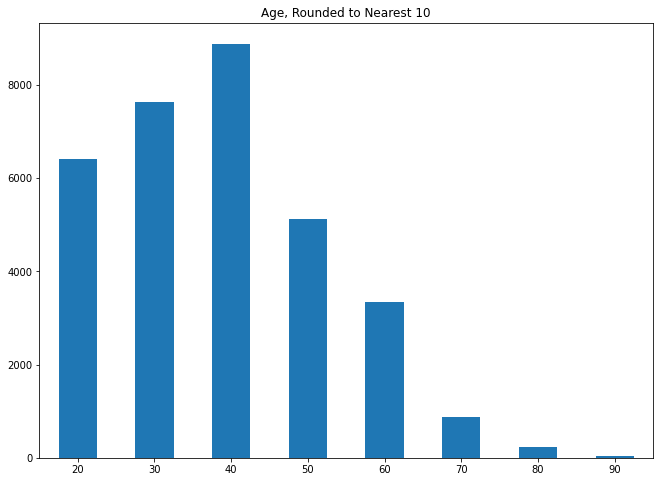

In [36]:
ax = table.age.round(-1).value_counts().sort_index().plot.bar(figsize=(11, 8), rot=0)

t = ax.title.set_text("Age, Rounded to Nearest 10")

We could also round to the nearest five, if we wanted to:

In [37]:
def custom_round(x, base=5):
    return (base * round(x.astype(float)/base)).astype(int)

In [38]:
custom_round(table.age).head(10)

0    40
1    50
2    40
3    55
4    30
5    35
6    50
7    50
8    30
9    40
Name: age, dtype: int64

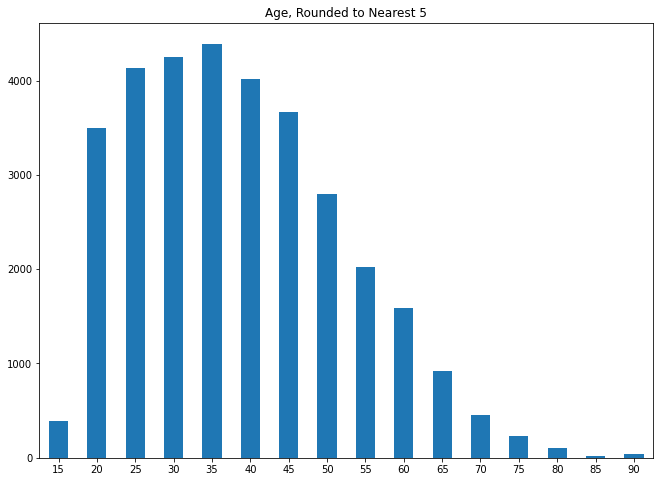

In [39]:
ax = custom_round(table.age).value_counts().sort_index().plot.bar(figsize=(11, 8), rot=0)

t = ax.title.set_text("Age, Rounded to Nearest 5")

Sometimes binning values can help for the purposes of interpretation; in the case of "noisy" data (or data with low-quality information), it can also help to engineer a little bit of information loss.

Let's move on another numeric column, `fnlwgt`, which the data's website describes as a statistically engineered field that's used by the government; we will do this through plotting a _histogram_, which we can do through the `DataFrame`'s `hist` method. I often use something like `bins=100`, but there exist [more elegant ideas](https://en.wikipedia.org/wiki/Freedman%E2%80%93Diaconis_rule) of how to calculate the number of bins to use. 

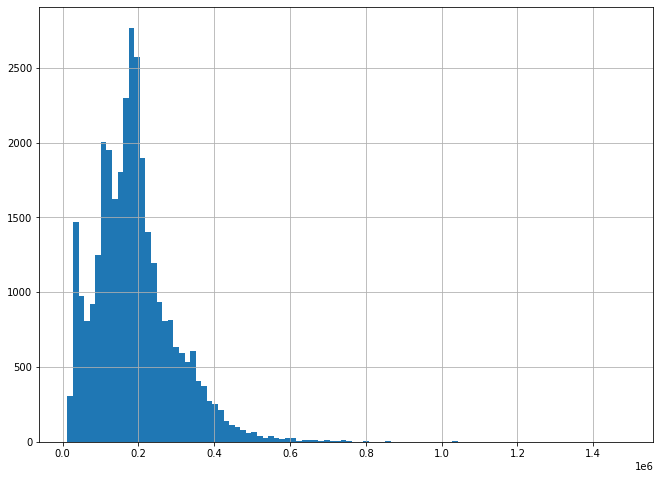

In [40]:
ax = table.fnlwgt.hist(bins=100, figsize=(11, 8))

This is interesting data -- we can see a "long" tail out to the right, so we'd consider this data to be _positively skewed_. Practically speaking, this means there are high-valued outliers that might "pull" the mean upwards from the rest of the data. Let's check this by comparing the mean to the median:

In [41]:
table.fnlwgt.agg(["mean", "median"])

mean      189780.848511
median    178356.000000
Name: fnlwgt, dtype: float64

In [42]:
table.fnlwgt.mean() / table.fnlwgt.median()

1.0640564293375385

Sometimes, when we see data that is skewed, it can be helpful to take a transform of it. Taking the _logarithm_ of data will strongly reduce data. The _square root_ will reduce skew more gently. The _cube root_ transform works well when dealing with negative values.

Let's try the `log` function from `numpy`:

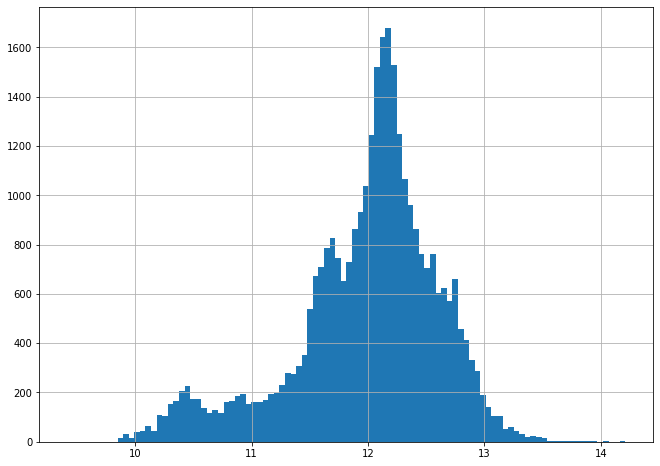

In [43]:
ax = np.log(table.fnlwgt).hist(bins=100, figsize=(11, 8))

In [44]:
fnlwgt_log = np.log(table.fnlwgt)

In [45]:
fnlwgt_log.mean() / fnlwgt_log.median()

0.991090097412325

We see that (by quick proxy of mean / median) skewness is reduced; this is apparent visually, too. "Squashing" the data like this can help in prediction problems! That said, remember that you are now in _log_ space, which means that you must un-transform (i.e. with `np.exp`) if you, for instance, train a model to log-transformed data but need to interpret in original units.

Let's take a look at another continuous column, `capital_gain`. 

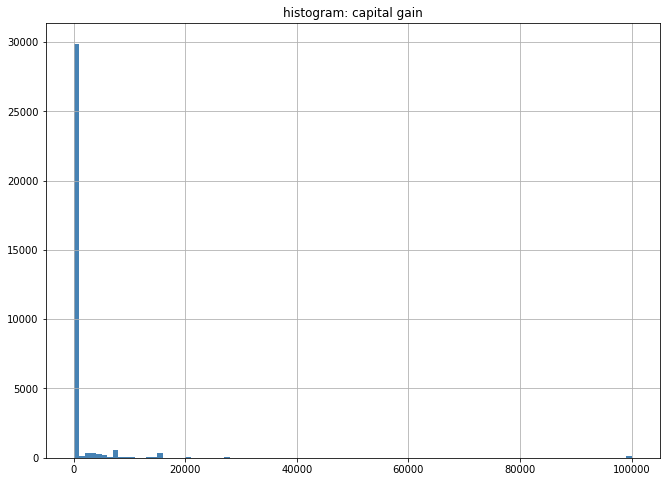

In [46]:
ax = table.capital_gain.hist(figsize=(11, 8), color="steelblue", bins=100)
ax.title.set_text("histogram: capital gain")

Wowza! How many people in this data set even have a non-zero capital_gain?

In [47]:
(table.capital_gain > 0).sum()

2712

So, less than 10% of the data. I wonder if a similar situation exists for `capital_loss`?

### --

### Problem

Determine the percentage of people in the data who have a non-zero value for `capital_loss`.

Then, confirm whether or not there is overlap between `capital_gain` and `capital_loss`. Hint: to check multiple conditions, each must be wrapped in its own set of paranetheses; you can use `|` for _or_ and `&` for _and_, depending on how you'd like to structure the conditions.

Next, create a new column, `capital_gain_net`, that combines the values in `capital_gain` and `capital_loss`. Visualize the results and do a quick write-up on what you have found. Feel free to home in on particular sections of the chart. 

### --

### Relational data analysis: the _group by_

Anyone who's done SQL before knows how valuable the _group by_ can be. 

For those unfamiliar, the basic idea is that you take column of categorical data, and group another column of data around it. Or, put differently, you bucket one column's data based on what values are, in each row, for some other column. And then, you apply some sort of aggregation function. 

Let's look at an example. Here, we'll look at average `capital_gain` when income is over $50K vs. when it's not:

In [55]:
table[["over_fifty_k_bool", "capital_gain"]
      ].groupby("over_fifty_k_bool"
      ).mean()

,capital_gain
over_fifty_k_bool,
False,148.884970
True,4007.164562


Interesting, or maybe, not? Folks earning over $50K per year had, on average, much higher capital gains. 

Let's throw standard deviation into the mix, which is always good to do as the mean alone can be misleading (see: skewness). First, we'll save our previous result into a new variable (I'm prefixing the variable name with an underscore so as to avoid cluttering the namespace):

In [56]:
_cap_gains_means = table[["over_fifty_k_bool", "capital_gain"]
                        ].groupby("over_fifty_k_bool").mean()

Next, let's rename the column so as to avoid ambiguity:

In [57]:
_cap_gains_means = _cap_gains_means.rename(
                            columns={"capital_gain": "capital_gain_mean"})

In [58]:
_cap_gains_means.columns

Index(['capital_gain_mean'], dtype='object')

Note that we could have achieved the same result by running: `_cap_gains_means.columns = ["capital_gain_mean"]`

Next, let's create the standard deviation result:

In [59]:
_cap_gains_std = table[["over_fifty_k_bool", "capital_gain"]
                        ].groupby("over_fifty_k_bool").std()

In [60]:
_cap_gains_std = _cap_gains_std.rename(
    columns={"capital_gain": "capital_gain_std"})

Finally, we can _join_ these tables together. For those unfamiliar, this is another important SQL concept in which we, using a common column (in this case, the row index), concatenate the columns of two (or more) tables together.

In [61]:
_cap_gains_means.join(_cap_gains_std)

,capital_gain_mean,capital_gain_std
over_fifty_k_bool,,
False,148.884970,963.557955
True,4007.164562,14572.097223


So, we have a much higher _average_ `capital_gain` with higher income, but also much more _volatility_. Let's quanitfy that on a relative basis.

In [62]:
_cap_gains_joined = _cap_gains_means.join(_cap_gains_std)

In [63]:
_cap_gains_joined["cap_gains_ratio"] = (
                                _cap_gains_joined.capital_gain_std /
                                _cap_gains_joined.capital_gain_mean
                            )

In [64]:
_cap_gains_joined

,capital_gain_mean,capital_gain_std,cap_gains_ratio
over_fifty_k_bool,,,
False,148.884970,963.557955,6.471828
True,4007.164562,14572.097223,3.636511


Interesting - *proportionately*, the low-income folks have more volatility.

Some **important** takeaways:
- always consider a mean alongside standard deviation
- thinking relatively (and thinking carefully about what your denominator is) can be very important

Do you think we could replicate this anlysis for our other numeric columns? Now, before we do that ... based on our knowledge of the data, we've (hopefully) noticed that `education` and `education_num` are, for all intents and purposes, identical - so let's kill one from `table`:

In [65]:
table = table.drop("education_num", axis=1)

### --

### Problem

Replicate the above group-by analysis, which we performed on `capital_gain`, on the other numeric columns in the data. Do this as programmatically as you can. Bonus points if you can figure out a way to measure the disparity between the results where `over_fifty_k` is `True`, and where it's `False`

### --

### Relational data analysis: _cross tabulations_

Can we do something similar for categorical data?

In [73]:
pd.crosstab(table.over_fifty_k_bool, table.marital_status).T

over_fifty_k_bool,False,True
marital_status,,
Divorced,3978,463
Married-AF-spouse,13,10
Married-civ-spouse,8280,6690
Married-spouse-absent,384,34
Never-married,10176,491
Separated,959,66
Widowed,908,85


The `pd.crosstab` function allows us to break down data into groups, based on the values the passed rows take for each of two columns, and returns the count for each group.

Let's save these results:

In [74]:
_cross_tabs = pd.crosstab(table.over_fifty_k_bool, table.marital_status).T

Get relative counts:

In [75]:
_cross_tabs = _cross_tabs / len(table)

Confirm our counts make sense:

In [76]:
_cross_tabs

over_fifty_k_bool,False,True
marital_status,,
Divorced,0.122261,0.014230
Married-AF-spouse,0.000400,0.000307
Married-civ-spouse,0.254480,0.205612
Married-spouse-absent,0.011802,0.001045
Never-married,0.312752,0.015091
Separated,0.029474,0.002028
Widowed,0.027907,0.002612


In [77]:
_cross_tabs.sum().sum()

1.0

Visualize results:

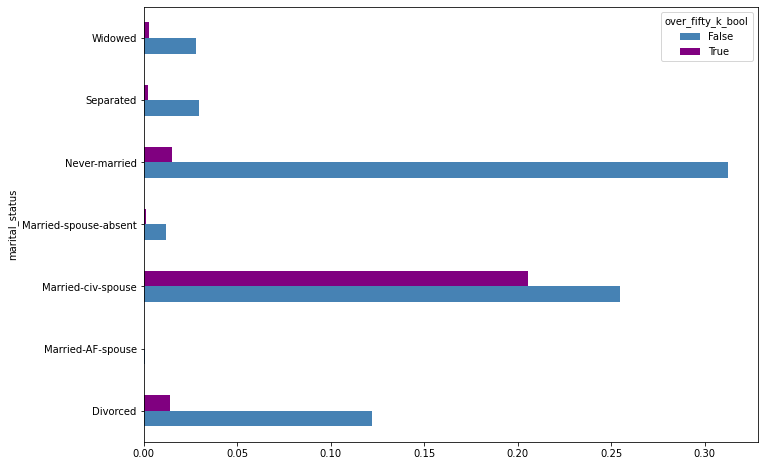

In [78]:
ax = _cross_tabs.plot.barh(figsize=(11, 8), color=["steelblue", "purple"])

Can we go even further, tabulating more than two columns? In fact, we can:

In [79]:
table[["over_fifty_k_bool", "marital_status", "sex"]
     ].groupby(["over_fifty_k_bool", "marital_status", "sex"]
     ).size().to_frame()

0
over_fifty_k_bool marital_status        sex         
False             Divorced              Female  2491
                                        Male    1487
                  Married-AF-spouse     Female     8
                                        Male       5
                  Married-civ-spouse    Female   903
                                        Male    7377
                  Married-spouse-absent Female   194
                                        Male     190
                  Never-married         Female  4594
                                        Male    5582
                  Separated             Female   614
                                        Male     345
                  Widowed               Female   779
                                        Male     129
True              Divorced              Female   179
                                        Male     284
                  Married-AF-spouse     Female     6
                                        Male       4
                  Married-civ-spouse    Female   754
                                        Male    5936
                  Married-spouse-absent Female    11
                                        Male      23
                  Never-married         Female   166
                                        Male     325
                  Separated             Female    17
                                        Male      49
                  Widowed               Female    46
                                        Male      39

Look at that monstrosity! Can we make it make a little more sense? Let's save it and give it a name:

In [80]:
_multi_tab = table[["over_fifty_k", "marital_status", "sex"]
                     ].groupby(["over_fifty_k", "marital_status", "sex"]
                     ).size().rename("size")

Using the `unstack` method, we can pop one of our row-level breakdowns into a columnar breakdown:

In [81]:
_multi_tab.unstack()

sex                                 Female  Male
over_fifty_k marital_status                     
<=50K        Divorced                 2491  1487
             Married-AF-spouse           8     5
             Married-civ-spouse        903  7377
             Married-spouse-absent     194   190
             Never-married            4594  5582
             Separated                 614   345
             Widowed                   779   129
>50K         Divorced                  179   284
             Married-AF-spouse           6     4
             Married-civ-spouse        754  5936
             Married-spouse-absent      11    23
             Never-married             166   325
             Separated                  17    49
             Widowed                    46    39

We can pick which level we pop out, too:

In [82]:
_multi_tab.unstack(0)

over_fifty_k                  <=50K  >50K
marital_status        sex                
Divorced              Female   2491   179
                      Male     1487   284
Married-AF-spouse     Female      8     6
                      Male        5     4
Married-civ-spouse    Female    903   754
                      Male     7377  5936
Married-spouse-absent Female    194    11
                      Male      190    23
Never-married         Female   4594   166
                      Male     5582   325
Separated             Female    614    17
                      Male      345    49
Widowed               Female    779    46
                      Male      129    39

And if we'd like to pop it back in:

In [83]:
_multi_tab.unstack(0).stack()

marital_status         sex     over_fifty_k
Divorced               Female  <=50K           2491
                               >50K             179
                       Male    <=50K           1487
                               >50K             284
Married-AF-spouse      Female  <=50K              8
                               >50K               6
                       Male    <=50K              5
                               >50K               4
Married-civ-spouse     Female  <=50K            903
                               >50K             754
                       Male    <=50K           7377
                               >50K            5936
Married-spouse-absent  Female  <=50K            194
                               >50K              11
                       Male    <=50K            190
                               >50K              23
Never-married          Female  <=50K           4594
                               >50K             166
                    

So, we could do this _all_ day (for many, many days...), but let's move on to feature selection. Before we go...

### --

### Problem

Think about the analyses we've performed and whether you wish we'd given any of them more time. Think about some more columns you might engineer out of the data we've got, and add _at least two_ new columns to `table`.

### --

# 3. Feature Selection

Choosing the right set of features can bring many benefits.

Some models don't work well with redundancy, so you'll want to choose features that are not too inter-related. Additionally, some datasets contain many, many columns, and reducing the amount of inputs to your model can drastically reduce the time it takes to prep your data and train your model. 

The benefits go on. In this case, we have a pretty simple feature set, but it will still help us to get a sense of what's the most predictive, which features overlap the most with other features, etc.

It should be noted that, when developing predictive models, you always need to be careful to *not base your performance benchmarks off of what you're training your models on*, and that goes even for feature selection - it's one thing to look at the entire dataset when you're exploring and looking for problems, but it's another to be programmatically making decisions around what to include in a model.

So we will start by taking 10% of our data out and putting it on the back burner - only for use at the very end, once we've already decided what our model and feature set are and once we're ready to just report performance estimates. We will take this 10% out _randomly_ and with respect to the _natural stratification_ of our target's clases (i.e. with respect for the balance of `True` / `False` in `over_fifty_k_bool`).

In [87]:
table.over_fifty_k_bool.value_counts(normalize=True)

False    0.759074
True     0.240926
Name: over_fifty_k_bool, dtype: float64

Here, we lean on `sklearn` for the random, stratified sampling:

In [88]:
train_inds, test_inds = train_test_split(table.index, test_size=.1, stratify=table.over_fifty_k_bool)

Next, we filter out any columns starting with `"over_fifty_k"` as we want to remove those from our feature set:

In [89]:
table_train = table.loc[train_inds, [c for c in table.columns if not c.startswith("over_fifty_k")]]

In [90]:
table_train.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'marital_status',
       'occupation', 'relationship', 'race', 'sex', 'capital_gain',
       'capital_loss', 'hours_per_week', 'native_country', 'capital_gain_net',
       'is_capital_gain', 'age_rounded'],
      dtype='object')

We'll keep this as our `y`:

In [91]:
fifty_k_train = table.loc[train_inds, "over_fifty_k_bool"]

### Feature redundancy

Let's start with looking at feature redundancy. There are many ways to do this, and one approach is to leverage *Euclidean distance*, which, between two vectors $p$ and $q$ is $\sqrt{ \sum_{i}^n (q_{i} - p_{i})^2}$

You might recognize this from the Pythagorean Theorem and this is a generalization of that idea. We are solving for the distance of the straight line that exists between each of the pairwise combinations of features in the data, where each row represents a "dimension" of measurement.

Why might one pursue this approach? _Correlation_ (Pearson's Coefficient, specifically) measures both direction and magnitude of a relationship between two variables; this method breaks down in the face of categorical data, for whom calculating magnitude (or even direction) may not be sensible. Thus, a more abstract measure of "distance" proves useful with mixed-type data.

See more [here](https://en.wikipedia.org/wiki/Euclidean_distance).

Let's work through some functionality to calculate this measure.

In [92]:
import itertools
from sklearn.preprocessing import MinMaxScaler


def euclidean(feature_one, feature_two):
    """
    Returns Euclidean distance between the two passed features. Both
    are assumed to be of type `pd.Series` or uni-column `pd.DataFrame`.
    """
    return np.sqrt(
                (feature_one - feature_two).pow(2).sum()
            )


def get_feature_iter_func(flat):
    """
    Helper function to determine what type of iteration to perform across two
    features. Takes `bool` as input.
    """
    if flat:
        return lambda feature_names: itertools.combinations(feature_names, 2)
    else:
        return lambda feature_names: itertools.product(feature_names, feature_names)


def normalize_min_max(df):
    """
    Uses min-max normalization to scale passed `pd.DataFrame` of values. Returns
    `pd.DataFrame` of transformed values with original row and column labels.
    """
    cols = df.columns
    inds = df.index

    arr = MinMaxScaler().fit_transform(df)
    return pd.DataFrame(arr, columns=cols, index=inds)


def feature_distances(distance_func):
    """
    Decorator for functions that calculate feature distances.
    `distance_func` is assumed to take as input, two features, likely in
    following the terms laid out in `euclidean`.
    This function will iterate through either the Cartesian Product (with
    `flat=True`) or all combinations of 2 (`flat=False`) of the specific
    features of the passed `DataFrame`. It will then return a nicely
    formatted `DataFrame` of results.
    Description of `inner` arguments, in order:
    - `pd.DataFrame` of data
    - `feature_names_list`, a list of  columns in `df` to compare
    - `flat`, boolean denoting result display style
    - `normalize_data`, which determines whether to min-max-scale data
    """
    def inner(df, feature_names_list, flat=True, normalize_data=True):
        if normalize_data:
            df = normalize_min_max(df[feature_names_list].astype(float))

        iter_func = get_feature_iter_func(flat)

        scores = [(f1, f2, distance_func(df[f1], df[f2]))
                  for f1, f2 in iter_func(feature_names_list)]

        scores_df = pd.DataFrame(scores, columns=["feature_one",
                                                  "feature_two",
                                                  f"{distance_func.__name__}"])

        if flat:
            scores_df = scores_df.set_index(["feature_one",
                                             "feature_two"]
                                ).sort_values(f"{distance_func.__name__}", 
                                              ascending=False)

        else:
            scores_df = scores_df.pivot(index='feature_one', 
                                        columns='feature_two', 
                                        values=f"{distance_func.__name__}")

        return scores_df

    return inner


@feature_distances
def euclidean_distances(feature_one, feature_two, **kwargs):
    """
    Wrapper allowing for running `euclidean` across many feature pairs.
    See `feature_distances` for more detail on how to pass arguments,
    and `euclidean` for details on metric calculation.
    """
    return euclidean(feature_one, feature_two)

In [93]:
euclideans = euclidean_distances(
                            table_train, # DataFrame
                            table_train.select_dtypes(include=[int, float, bool]).columns # column names
                        )

In [94]:
euclideans.shape

(28, 1)

So what are we looking for here? We want to find the features that are too "close" together (i.e. the value for `euclidean_distances` is small):

In [95]:
euclideans

euclidean_distances
feature_one      feature_two                          
hours_per_week   is_capital_gain             74.411005
capital_gain     hours_per_week              71.261225
capital_loss     hours_per_week              70.463103
age              is_capital_gain             65.028980
hours_per_week   capital_gain_net            64.723695
is_capital_gain  age_rounded                 63.243617
age              capital_gain                59.202386
                 capital_loss                58.693449
capital_gain     age_rounded                 56.221869
capital_loss     age_rounded                 55.849478
fnlwgt           hours_per_week              54.405377
age              capital_gain_net            53.575569
capital_loss     is_capital_gain             52.149098
capital_gain_net age_rounded                 50.995886
fnlwgt           is_capital_gain             49.472241
age              fnlwgt                      46.213291
hours_per_week   age_rounded                 45.885050
fnlwgt           age_rounded                 44.727167
capital_gain     is_capital_gain             44.556013
capital_gain_net is_capital_gain             43.221720
age              hours_per_week              41.617678
fnlwgt           capital_loss                26.440063
                 capital_gain                25.694800
capital_loss     capital_gain_net            21.477232
fnlwgt           capital_gain_net            20.892833
capital_gain     capital_loss                20.660519
age              age_rounded                  8.943991
capital_gain     capital_gain_net             6.972445

In [96]:
euclideans.describe()

,euclidean_distances
count,28.000000
mean,46.321421
std,18.645207
min,6.972445
25%,37.823275
50%,50.234063
75%,58.820683
max,74.411005


There are diffrent approaches we could take in deciding what is too small:
- pick some statistic (e.g. the `mean`, or the `25th percentile`) and use that as a cutoff
- create a histogram, and look for upper bound of the first "chunk"
- look at the data and take a more heuristic approach

I'm going to start by cutting to below the 25th percentile:

In [97]:
cutoff = euclideans.euclidean_distances.quantile(.25)

In [98]:
euclideans[euclideans.euclidean_distances < cutoff]

euclidean_distances
feature_one  feature_two                          
fnlwgt       capital_loss                26.440063
             capital_gain                25.694800
capital_loss capital_gain_net            21.477232
fnlwgt       capital_gain_net            20.892833
capital_gain capital_loss                20.660519
age          age_rounded                  8.943991
capital_gain capital_gain_net             6.972445

There are a couple of places that might make for a good cutoff point. Let's get a nice, pairwise view of the features we're trying to remove:

In [99]:
list(euclideans[euclideans.euclidean_distances < cutoff].index)

[('fnlwgt', 'capital_loss'),
 ('fnlwgt', 'capital_gain'),
 ('capital_loss', 'capital_gain_net'),
 ('fnlwgt', 'capital_gain_net'),
 ('capital_gain', 'capital_loss'),
 ('age', 'age_rounded'),
 ('capital_gain', 'capital_gain_net')]

There exist some more automated mechanisms we could use for choosing a cutoff point. But, based on the above analysis, I'd definitely consider killing one from each of the above-selected pairs.

We can always add these columns back in later. (Let's preserve a copy with all columns before we start eliminating anything.)

In [100]:
table_train_copy = table_train.copy()

Now, let's remove one feature from each of the above pairs:

In [101]:
_pairs_to_kill = list(euclideans[euclideans.euclidean_distances < cutoff].index)

In [102]:
_to_kill = list(map(lambda pair: pair[0], _pairs_to_kill))

In [103]:
_to_kill

['fnlwgt',
 'fnlwgt',
 'capital_loss',
 'fnlwgt',
 'capital_gain',
 'age',
 'capital_gain']

In [104]:
table_train = table_train.drop(list(set(_to_kill)), axis=1)

In [105]:
table_train.shape

(29283, 12)

Again, the concept of "distance" works well when you have a combination of numeric and categorical data (as we do) and you're looking for a one-stop shop for eliminating redundant features.


To be thorough, you could also check correlations on numerical data. Let's work through how we would use correlation to eliminate certain features, as this could make for a good exercise:

In [106]:
corrs = table_train_copy.corr()

In [107]:
corrs

,age,fnlwgt,capital_gain,capital_loss,hours_per_week,capital_gain_net,is_capital_gain,age_rounded
age,1.000000,-0.074245,0.074140,0.059319,0.067220,0.070671,0.119502,0.979009
fnlwgt,-0.074245,1.000000,-0.000643,-0.010014,-0.019685,-0.000095,-0.008112,-0.074537
capital_gain,0.074140,-0.000643,1.000000,-0.031695,0.078427,0.998516,0.484246,0.074128
capital_loss,0.059319,-0.010014,-0.031695,1.000000,0.056176,-0.086076,-0.065453,0.058017
hours_per_week,0.067220,-0.019685,0.078427,0.056176,1.000000,0.075115,0.075337,0.064851
capital_gain_net,0.070671,-0.000095,0.998516,-0.086076,0.075115,1.000000,0.486258,0.070729
is_capital_gain,0.119502,-0.008112,0.484246,-0.065453,0.075337,0.486258,1.000000,0.118492
age_rounded,0.979009,-0.074537,0.074128,0.058017,0.064851,0.070729,0.118492,1.000000


Notice that only the correlations for numeric data are returned.

The correlation matrix above obviously contains redundant information, so let's grab a distinct set of correlation values, which we can achieve through some `numpy` magic. Let's get a representation of our row indices:

In [108]:
corr_rows = np.arange(corrs.shape[0])[:,None] 

In [109]:
corr_rows

array([[0],
       [1],
       [2],
       [3],
       [4],
       [5],
       [6],
       [7]])

Now, let's get a representation of our column indices:

In [110]:
corr_cols = np.arange(corrs.shape[1])

In [111]:
corr_cols

array([0, 1, 2, 3, 4, 5, 6, 7])

Now, we can create a boolean mask (as we've done above with thing like `table.duplicated()` or `table.age > 30`) through checking to see whether each value in `corr_rows` is less than or equal to the corresponding value in `corr_cols`.

This mask will select only the *lower triangle* (so redundant values above are eliminated) and even further will not select the diagonal of the matrix. You'll see, shortly, why that's important.

Based on how we've set this up, `numpy` will automatically blow this out into a matrix represenation:

In [112]:
corr_mask = corr_rows <= corr_cols

In [113]:
corr_mask

array([[ True,  True,  True,  True,  True,  True,  True,  True],
       [False,  True,  True,  True,  True,  True,  True,  True],
       [False, False,  True,  True,  True,  True,  True,  True],
       [False, False, False,  True,  True,  True,  True,  True],
       [False, False, False, False,  True,  True,  True,  True],
       [False, False, False, False, False,  True,  True,  True],
       [False, False, False, False, False, False,  True,  True],
       [False, False, False, False, False, False, False,  True]])

Now, why do we have `False` in the area that (as per the above description) we actually want to select? That has to do with how a function we'll call below (`corrs.mask`) works ... it keeps the passed data wherever there is `False`, and replaces with whatever is specified (defaults to `np.nan`) wherever there is `True`.

In [114]:
corr_mask.shape

(8, 8)

In [115]:
corrs_unique = corrs.mask(corr_mask)

In [116]:
corrs_unique

,age,fnlwgt,capital_gain,capital_loss,hours_per_week,capital_gain_net,is_capital_gain,age_rounded
age,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fnlwgt,-0.074245,NaN,NaN,NaN,NaN,NaN,NaN,NaN
capital_gain,0.074140,-0.000643,NaN,NaN,NaN,NaN,NaN,NaN
capital_loss,0.059319,-0.010014,-0.031695,NaN,NaN,NaN,NaN,NaN
hours_per_week,0.067220,-0.019685,0.078427,0.056176,NaN,NaN,NaN,NaN
capital_gain_net,0.070671,-0.000095,0.998516,-0.086076,0.075115,NaN,NaN,NaN
is_capital_gain,0.119502,-0.008112,0.484246,-0.065453,0.075337,0.486258,NaN,NaN
age_rounded,0.979009,-0.074537,0.074128,0.058017,0.064851,0.070729,0.118492,NaN


Now we have a correlation matrix with no redeundant values and no diagonal. Why? So that we can get an ordered view that allows us to remove the most-correlated features.

In [117]:
corrs_unique.unstack().rename("correlation").abs().to_frame().sort_values("correlation", ascending=False).head(10)

correlation
capital_gain     capital_gain_net     0.998516
age              age_rounded          0.979009
capital_gain_net is_capital_gain      0.486258
capital_gain     is_capital_gain      0.484246
age              is_capital_gain      0.119502
is_capital_gain  age_rounded          0.118492
capital_loss     capital_gain_net     0.086076
capital_gain     hours_per_week       0.078427
hours_per_week   is_capital_gain      0.075337
                 capital_gain_net     0.075115

To compare this to the above Euclidean distance method, notice that our very-correlated features line up with some of those that we'd already slated for removal. But, note that some features that we found to be "close" are not necessarily *correlated* - interesting, isn't it?

Remember that when people say "correlation" they are generally referring to *Pearson's correlation coefficient* ([wikipedia](https://en.wikipedia.org/wiki/Correlation_and_dependence#Pearson's_product-moment_coefficient)). To understand how that works, let's first look at [covariance](https://en.wikipedia.org/wiki/Covariance):

$$ cov(X, Y) = E[(X - E[X])(Y - E[Y])] $$

In English, that's:
1. take `X`, and subtract its mean from each of its values
2. take `Y`, and subtract its mean from each of its values
3. take the product of 1. and 2.
4. take the mean of 3.

Let's think about how that works ...

If $X_{1} - E[X]$ is negative, but $Y_{1} - E[Y]$ is positive, the product of that will be negative. If they're both positive, the product is positive; same for if they're both negative. That's how "direction" plays in here. As for "magnitude", the bigger the difference between `X` and its mean tends to be, the bigger the *covariance* between X and anything else; ditto for `Y`.

Finally, to get correlation from covariance, we scale by the product of the standard deviations of `X` and `Y`, which keeps the result between -1 and 1:

$$ corr(X, Y) = \frac {cov(X, Y)}{\sigma_X \sigma_Y}$$

### Feature Selection

Now, let's get into picking the _good_ features. 

To do this, we're going to need to do a little data prep. This data prep entails _one-hot_ (or *dummy*) encoding our `object` columns. 

What this entails is taking a single column of categorical data and converting it into a number of columns - as many columns as there are values for the categorical variable - of boolean data, with a each column representing a particular categorical value.

Let's look at an example:

In [118]:
table_train.sex.head()

24765    Female
21697      Male
31010      Male
8266       Male
21044      Male
Name: sex, dtype: object

In [119]:
pd.get_dummies(table_train.sex.head())

,Female,Male
24765,1,0
21697,0,1
31010,0,1
8266,0,1
21044,0,1


So instead of five rows, each containing `"Female`" or `"Male"` we now have five rows, each containing a `1` in the `Male` and `0` in the `Female` column if `sex="Male"`, or vice versa if  `sex="Female"`.

Note that there does not have to be mutual exclusivity between the columns that result from a one-hot encoding. If there _is_ mutual exlusivity, it is good practice to drop one of your resulting columns, lest you introduce some redundancy into your feature set. E.g. we wouldn't want to represent `over_fifty_k` with two columns `over_fifty_k` and `equal_to_or_under_fifty_k`, right?

In this case, we're going to quickly iterate through each `object` column, perform the encoding, and drop one of the resulting columns. We're also going to prefix each of our resulting columns with the name of the column that the value originall came from, to avoid possible name collisions:

In [120]:
_one_hots = [
                pd.get_dummies(
                    table_train[col],
                    drop_first=True,
                    prefix=col
                )
             for col in table_train.select_dtypes(include=object).columns]

Now we have a list of `pd.DataFrame` objects - let's spot-check the first one:

In [121]:
_one_hots[0].iloc[:3, :3]

,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked
24765,0,0,0
21697,0,0,0
31010,0,0,0


How do we join these dataframes together? One way to do that is through joining the first to the rest:

In [122]:
one_hot_df = _one_hots[0].join(_one_hots[1:])

In [123]:
one_hot_df.shape

(29283, 94)

In [124]:
one_hot_df.iloc[:5, :5]

,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc
24765,0,0,0,1,0
21697,0,0,0,1,0
31010,0,0,0,1,0
8266,0,0,0,1,0
21044,0,0,0,0,1


I am also going to eliminate `-` in the column names, because that can get annoying:

In [125]:
one_hot_df.columns = one_hot_df.columns.str.replace("-", "_")

Now we can create our `X` and `y` variables. For `X`, we'll join the one-hot columns to our numeric data: 

In [126]:
X = one_hot_df.join(table_train.select_dtypes(include=[int, float]))

In [127]:
X.shape

(29283, 97)

In [128]:
table_train.dtypes.value_counts()

object    8
int64     3
bool      1
dtype: int64

You can see that we have no more `object` columns:

In [129]:
X.dtypes.value_counts()

uint8    94
int64     3
dtype: int64

For `y` (which we typically lowercase to indicate that it is not a matrix but a vector), we don't have to do any prep:

In [130]:
y = fifty_k_train

Next, we're going to create a _Random Forest Classifier_. What's that mean? Let's break it down.

--

### Some Theory

**Classification**

For starters, a [classifier](https://en.wikipedia.org/wiki/Statistical_classification) is a model that predicts a class or label, as opposed to a numeric value - i.e. it's built for predicting categorical data. In this case, we're going to -- for all intents -- restrict our definitions to [binary classification](https://en.wikipedia.org/wiki/Binary_classification) (where our target, what we're predicting, can only take one of two values). 

**Decision Tree Learning**

A _Decision Tree_ [is](https://en.wikipedia.org/wiki/Decision_tree_learning) a model that builds a series of rules, kind of like the game _twenty questions_. E.g is `age >= 15`? It typically does this repeatedly until it has created a number of *pure* (or close to it) "leaves" or terminal nodes such that each of these nodes strongly represents a particular class value. In more detail, we train a decision tree through, basically:
- iterating through the available features and the available values for each of those features
- evaluating the effectiveness of each of those feature values when it comes to splitting the data into groups that represent a particular class
- selecting the most effective feature-value rule (e.g. `age >= 30`) or "splitting rule" and splitting the data based on that rule
- we then apply the same process to each of the resultant groups (e.g. `age >= 30` and `age < 30`) and continue doing so until we have found our "pure" nodes

What is a pure node? The idea is that, once our tree is built (i.e. trained), we can make a prediction through propagating a data point through the rules in the tree (e.g. `age >= 30`, `sex == Female`) until we've reached a partition of the data that, in our training, we found to be associated with one particular class. We then return the class associated with our final partition as our "prediction."

What's been described has been maybe a little bit simplified but should provide a good idea of the foundational concepts.

**Splitting Rule Evaluation**

Purity here refers to the distributional concentration of the data towards a particular class. Put differently, we can think about the probability of how often a randomly chosen item would be mislabeled, if all we had to go off was the class probabilities across the entirety of the given data. To calculate this number, we must account for the following:
- probability of drawing a random item with a certain class label (let's call this `p`)
- probability that this data will have come from another class (this is in fact `1 - p`)

(this is of course assuming that a given data point can belong to exactly one class.) Since these two conditions are independent, we simply multiply them together, yielding:

$$ p \cdot (1 - p) $$

and at a given node. Note that this is a quadratic function, with a max at $p=50\%$; in other words, the highest possible misclassification rate, i.e. least useful possible splitting rule, occurs when we just split the data 50 / 50 (assuming that classes are evenly balanced; there is weighting that can be done to account for imbalanced classes); and the lowest misclassification rate or highest "purity" occuring when a node consists entirely of one class or the other.

In [131]:
p = np.arange(0, 1, .01)

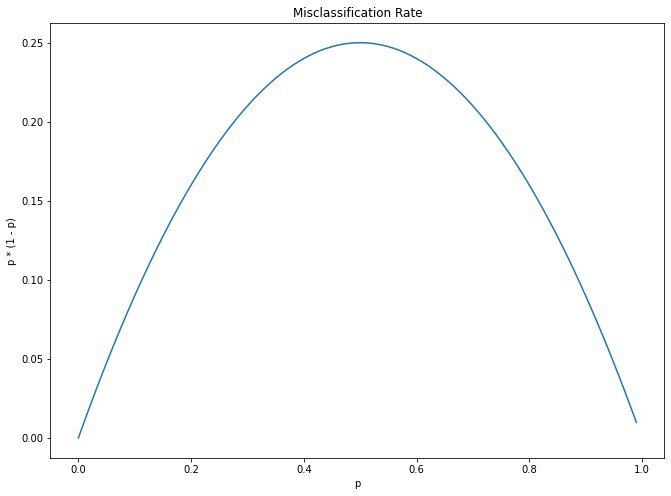

In [132]:
ax = pd.Series(p * (1 - p), index=p).plot(figsize=(11, 8))
_ = ax.set_xlabel("p")
_ = ax.set_ylabel("p * (1 - p)")
_ = ax.title.set_text("Misclassification Rate")

At each node, we can sum this result across all classes to get what's called [Gini impurity](https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity), which provides a good measure for the effectiveness of a given splitting rule in partitioning the data according to its class labels. Now that we have a good measure for splitting rule effectiveness, we can choose our splitting rule such that it provides the greatest reduction in impurity from the previous node.

**Tree Depth**

If we let a decision tree grow, uninhibited, until all of its leaves are pure, we will likely end up with a tree that has *overfit*; i.e. so tightly coupled to the data it was trained on that it won't generalize well. Thus we will often implement something to prevent the tree from becoming too deep, through setting something like a specific number of levels that a tree can't exceed, or a minimum number of items that can end up in a leaf / terminal node.

**Random Forest**

So what's a *Random Forest*? The idea is that, in trying to prevent overfitting, we build a whole bunch of decision trees, such that each tree is a little bit different, and take the average across all these trees' votes to produce a prediction.

In a little more detail, a [random forest](https://en.wikipedia.org/wiki/Random_forest) generally relies on the following procedures in order to ensure that there is *variance* across its trees' structures:
- each tree is based off its own [bootstrap sample](https://en.wikipedia.org/wiki/Random_forest#Bagging), or random resampling with replacement, of the underlying data
- a random subset of the available features will be used each time a new splitting rule is to be defined

It's worth noting that random forests are models for which it is desirable to limit redundancy in features, as redundant features will limit the effectiveness of creating a number of different trees using random subsets of the feature space.

--

So, what are going to use a random forest for? We're actually going to build a machine learning model, and retrain it to different subsets of the feature space, and use feature contributions to help us determine what our most useful features are.

We're going to set this forest to build 10 trees (in practice, it's good to use 100), and pass another argument for `class_weight`, which we'll get to in a bit:

In [133]:
rf = RandomForestClassifier(n_estimators=10, class_weight="balanced")

Now, we'll use something called the *recursive feature eliminator* (`RFE`) to help us determine which features are worth keeping. In practice, [permutation importance](https://scikit-learn.org/stable/modules/permutation_importance.html) is the preferred method for this, but the `RFE` is kind of an intuitive and interesting trick to see.

The way the `RFE` works is as follows:
- we pass it a model to use (in our case, `rf`) as well as the number of features we're looking to keep (in our case, `10`)
- then, we fit it to some data
- from there, it will evaluate the effectiveness of each feature, and it will eliminate the least effective feature
- it will then continue this process, [recursively](https://en.wikipedia.org/wiki/Recursion_(computer_science)) (hence its name), until the desired number of features remain

How does it determine the effectiveness of each feature? It actually leans on the inputted model for that, and what the random forest uses is Gini impurity - it will look across each split in each of its trees, sum up the reductions to impurity, by feature, and return these results.

Now, why is *permutation importance* preferred? Because relying on Gini to interpret features can lead to results that favor features with a high [cardinality](https://en.wikipedia.org/wiki/Cardinality). But, the interpretability of tree-based models is interesting and is worth learning about, and we'll work with that method here.

In [134]:
selector = RFE(rf, n_features_to_select=10)

In [135]:
selector.fit(X, y)

RFE(estimator=RandomForestClassifier(class_weight='balanced', n_estimators=10),
    n_features_to_select=10)

These are the top 10 columns that were selected:

In [136]:
sorted(list(X.columns[selector.support_]))

['age_rounded',
 'capital_gain_net',
 'education_Bachelors',
 'hours_per_week',
 'marital_status_Married_civ_spouse',
 'marital_status_Never_married',
 'occupation_Exec_managerial',
 'occupation_Prof_specialty',
 'relationship_Not_in_family',
 'sex_Male']

In [137]:
good_cols = sorted(list(X.columns[selector.support_]))

In [138]:
ranks = pd.DataFrame(
    list(zip(X.columns, selector.ranking_)), 
    columns=["column_name", "rank_survived_until"]
                     ).sort_values("rank_survived_until")

Let's look at the 10 worst:

In [139]:
ranks.iloc[-10:]

,column_name,rank_survived_until
90,native_country_Trinadad&Tobago,79
59,native_country_Ecuador,80
86,native_country_Scotland,81
80,native_country_Outlying_US(Guam_USVI_etc),82
7,workclass_Without_pay,83
89,native_country_Thailand,84
30,occupation_Armed_Forces,85
68,native_country_Honduras,86
2,workclass_Never_worked,87
67,native_country_Holand_Netherlands,88


Let's retain these particularly bad ones and drop them out of our data:

In [140]:
crummy_features = ranks.iloc[-10:].column_name

In [141]:
X = X.drop(crummy_features, axis=1)

# 3. Machine Learning

Let's build a model, and let's evaluate it (at least somewhat) properly.

### Class imblanace

One thing I cannot stress enough is the need to keep in mind the balance of the classes in the data you have. For example, let's say I start with the following model, which will simply return `0` (i.e. `False`) for each row in the inputted `X`:

In [142]:
def crummy_model(X):
    return np.zeros((len(X),))

In [143]:
y_pred = crummy_model(X)

In [144]:
accuracy_score(y, y_pred)

0.7590752313629068

What?! All we did we literally return 0 for every value! How is our accuracy so good?

In [145]:
y.value_counts(normalize=True)

False    0.759075
True     0.240925
Name: over_fifty_k_bool, dtype: float64

Wait a second ... that's a perfect match for the natural distribution of classes in the data. And now you've seen the danger of class imblanace - when you have more of one class than the other, if you just always pick the _majority_ class, you'll have a model that looks decent (at least if you are using "accuracy" to evaluate it).

This is what the `class_weights` argument to our model is for - it tells the forest to build each tree based off a _class-balanced_ subset of the data.

### Scores

So, how do we protect ourselves, aside from setting the right model parameters, against falling into that sort of trap?

The above example showed that accuracy, though a nice thumb-in-the-air sort of metric, and also a metric that lots of managers will enjoy discussing, can be pretty dangerous to use. There are better scores, for sure, but one thing you can always do with your prediction results is *look* at them, instead of just rolling them up into a score.

Enter the [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html), whose rows represent the actual class value and whose columns represent the predicted class value. `sklearn` implements this for us, and we will wrap their function to better format the results:

In [146]:
def get_confusion(y, y_pred):
    # with score functions, especially in sklearn, we always pass y or y_true and then y_pred
    matrix = confusion_matrix(y, y_pred)
    
    df = pd.DataFrame(matrix,
                     index=["negative_actual", "positive_actual"],
                     columns=["negative_predicted", "positive_predicted"])
    
    return df

In [147]:
get_confusion(y, y_pred)

,negative_predicted,positive_predicted
negative_actual,22228,0
positive_actual,7055,0


Looking at the above, we can see clearly that all our model did was predict `negative`.

A little bit more on the confusion matrix: the diagonal (i.e. positions `(0,0)` and `(1, 1)`) hold the correct predictions. Points falsely predicted as positive are known as *false positives* (FP), and points correctly predicted as positive are known as *true positives* (TP) - the same nomenclature holds on the negative side.

We can get *accuracy* score from the above through taking the following ratio:

$$ accuracy = \frac {TP + TN}{TP + TN + FP + FN}$$

i.e. we take the number of correct predictions (or predictions on the diagonal) and divide that by the total number of predictions. But we can get some more nuanced measures here, too. If the above is our overall accuracy, what if we broke that down into two, let's say this colloquially, components? For instance:
1. a model's carefulness
2. a model's thoroughness

How might we calculate these scores? Maybe for "carefulness," we could do:

$$ precision = \frac{TP}{TP + FP}$$

The above is the ratio of correct, positive predictions to the number of total positive predictions - i.e. of all the times the model predicted *positive*, what proportion of those predictions were correct? Maybe for "thoroughness," we could do:

$$ recall = \frac{TP}{TP + FN} $$

The above is the ratio of correct, positive predictions to the number of total actual positive values - i.e. out of all the actual positive values in the data, what proportion did the model correctly identify?

Which you might use depends on what you trying to solve for, and what the consequences of different types of mistakes are. It's almost like different styles of poker players - some bet carefully, preserving their bankroll, while some bet aggressively, not wanting to miss an opptortunity to make money. Or, for another example, it could be like talking to people at a cocktail party - do you want to speak only to people who you think have a good chance of responding to you, or do you want to speak to as many people as possible?

And, interestingly, there's a [tradeoff](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html) between precision and recall - lower your decision threshold and you'll identify more positives (higher recall) less precisely (i.e. with more false positives). Often times you want to account for both precision *and* recall, and there a number of other scores one can look to in evaluating a predictive model. For instance, the [f1 score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) is the harmonic mean of precision and recall.

For now, the 3 scores we've covered, along with the confusion matrix, should provide a great starting point.

### Cross-validation

So how do we actually evaulate our models? We generally:
- pick some kind of scoring metric
- run several trials using different samples of the data
- take the aggregate (usually the *mean*) score across these trials as our meeasure of model performance

There are some mechanics to how we achieve this. The standard, applicable to many problems, is [cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)). In cross-validation, we break the data into chunks or "folds" - for the sake of example, let's say 5. We take 4 of those folds and use them to train a model, and test that model on the other fold (or "hold-out" or "test" fold). Then, we repeat that process, inserting the previous test fold back into the train set, and taking a different train fold out as the test set. We do this until we've tested on all 5 folds and then typically report the average (and maybe standard deviation) performance across these folds.

Some additional details:
- cross validation (CV) is often referred to as *k-fold cross validation*, where `k` represents the number of folds used (in the above example, 5)
- the data is typically sampled randomly into the k folds
- in classification, [stratified](https://en.wikipedia.org/wiki/Stratified_sampling) random sampling is used, such that the given class distributions are preserved within each fold

So, this whole process is kind of like what we did above, with our "hold-out" set that we're using for our final, reported performance estimates, except that we are repeating the process several times. Why?
- we can evaluate the model's performance across every provided data point (as we test on every fold)
- we avoid ever evaluating the model's results on the data that it was trained it on

Finally, why the exterior or initial 90 / 10 breakdown, in addition to CV? That's because we use CV for making decisions like:
- which features to use
- which model to use
- how to tune that model

and we want to have fresh data to report our final estimates on that was not used as part of the feature or model selection processes. Let's try this out! We'll use the implementation from [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html):

In [148]:
rf = RandomForestClassifier(n_estimators=10, class_weight="balanced")

Accuracy:

In [149]:
accs = cross_val_score(rf, X, y, scoring=make_scorer(accuracy_score), cv=5)

In [150]:
np.mean(accs), np.std(accs)

(0.831881967632957, 0.005850958689482836)

Precision:

In [151]:
precs = cross_val_score(rf, X, y, scoring=make_scorer(precision_score), cv=5)

In [152]:
np.mean(precs), np.std(precs)

(0.6450458549059814, 0.015017844111903158)

Recall:

In [153]:
recs = cross_val_score(rf, X, y, scoring=make_scorer(recall_score), cv=5)

In [154]:
np.mean(recs), np.std(recs)

(0.6710134656272146, 0.016032681130747215)

So our accuracy is way higher than our precision, which is also a good bit higher than our recall - this large disparity amongst scores can be a good indicator that a model is not fitting to the data well.

### Hyper-parameter tuning

An obvious goal when selecting the model is to avoid *underfitting* - i.e. we want our model to fit the data well. But, as mentioned before, we also want to avoid *overfitting*, or building a model that is too tightly coupled to the data it's trained on.

There's actually a great concept that encapsulates this relationship, and that's the [bias-variance tradeoff](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff). The idea is that, generally speaking, there's a tradeoff between a model being correct and a model being consistent. A model that will, at least on some data, predict certain data with high accuracy may offer much worse performance on other data (i.e. there's "variance" in its performance). On the other hand, a model that is restricted from building a tight fit to any particular data may produce predictions that are wrong (or "biased").

We evaluate fit by comparing our train scores to the test scores. In other words, in addition to retaining performance on each of our hold out sets, we also retain performance when predicting the data the model is trained on. We must **never** report train scores, but they can prove useful when compared to test scores. If there's a large disparity - let's say, greater than 5% - then the model is likely overfitting.

How do we handle that? Most models have some *hyper-parameters* - parameters you pass to the model creation process, as opposed to the data that you pass to the model fitting proces - that will restict a model from establishing too tight of a fit. With *logistic regression*, you can control [regularization](https://en.wikipedia.org/wiki/Regularization_(mathematics)) in order to force the model's coefficients to stay near 0. With a random forest, you can control the [depth of a tree](https://en.wikipedia.org/wiki/Decision_tree_pruning).

In [155]:
results = cross_validate(rf, X, y, scoring=make_scorer(recall_score), cv=5, return_train_score=True)

In [156]:
results_train = pd.Series(results["train_score"], name="train")

In [157]:
results_test= pd.Series(results["test_score"], name="test")

In [158]:
results_train.to_frame().join(results_test)

,train,test
0,0.931609,0.676825
1,0.930191,0.658398
2,0.928774,0.661233
3,0.926471,0.671155
4,0.931963,0.683912


We can see quite a disparity here! I wonder what will happen if we limit tree depth?

In [159]:
rf_depth = RandomForestClassifier(n_estimators=10, class_weight="balanced", max_depth=16)

In [160]:
results = cross_validate(rf_depth, X, y, scoring=make_scorer(recall_score), cv=5, return_train_score=True)

In [161]:
results_train = pd.Series(results["train_score"], name="train")

In [162]:
results_test= pd.Series(results["test_score"], name="test")

In [163]:
results_train.to_frame().join(results_test)

,train,test
0,0.908930,0.862509
1,0.923281,0.832034
2,0.924522,0.844082
3,0.922573,0.862509
4,0.918143,0.860383


Wow - a big difference! By the way, if we wanted to evaluate based on limiting the size of the leaves in the trees, as opposed to explicitly limiting the depth of the tree, you could tweak the `min_samples_leaf` hyper-parameter. These methods are probably pretty comparable in practice but maybe offer different interpretations, each of which might fit certain datasets or problems better.

A good tecnhique is to evaluate a model's performance over different hyper-parameter values. `sklearn` has [implemented](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) something called `GridSearchCV`, which will perform an exhaustive search over the different parameter values you pass. This is a great tool, and makes setting up automated build pipelines much easier.

Let's visualize performance over different `max_depth` values (following [this example](https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html) from `sklearn`):

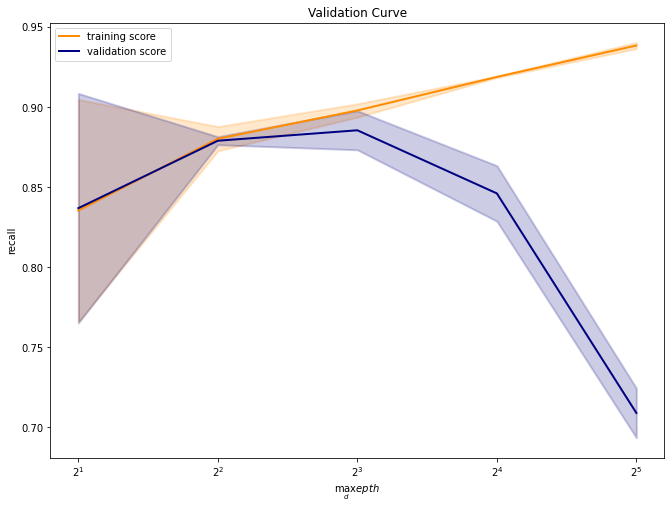

In [164]:
param_range = [2**x for x in range(1, 6)]
other_hp = {"n_estimators": 10, "class_weight": "balanced"}

train_scores, test_scores = validation_curve(
    RandomForestClassifier(**other_hp),
    X,
    y,
    param_name="max_depth",
    param_range=param_range,
    scoring="recall"
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(11, 8))

plt.title("Validation Curve")
plt.xlabel(r"$\max_depth$")
plt.ylabel("recall")

lw = 2
plt.semilogx(
    param_range, train_scores_mean, base=2,
    label="training score", color="darkorange", lw=lw
)
plt.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
plt.semilogx(
    param_range, test_scores_mean, base=2,
    label="validation score", color="navy", lw=lw
)
plt.fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)

plt.legend(loc="best")
plt.show()

We see train and validation data staying close together at lower values and diverging as we let the tree grow deeper -- we'll want to select a `max_depth` value that keeps the two scores close enough together, while also letting validation (which we'll use for selecting a model) get as high as reasonably possible.

Now, we can also consider precision, and a good way to compare precision to recall is through looking at a *precision-recall curve*; to do this, we're going to sub-sample `X` and `y` to get separate train and validation sets.

In [166]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=.2, stratify=y)

Next, let's plot the curve (drawing from [this example](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#plot-the-precision-recall-curve) from `sklearn`):

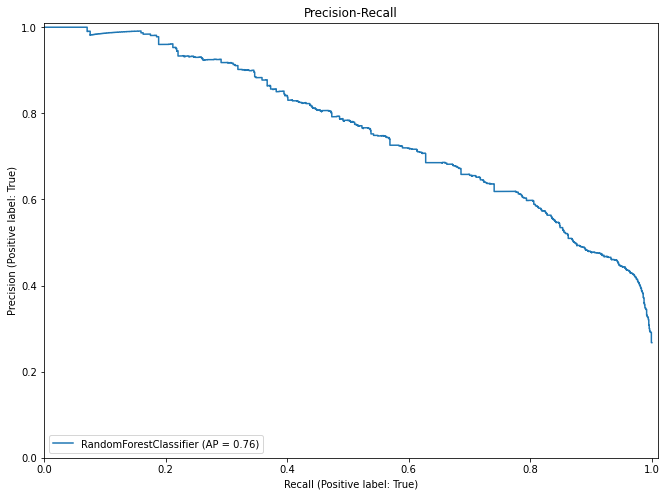

In [178]:
clf = RandomForestClassifier(max_depth=8, **other_hp).fit(X_train, y_train)

fig, ax = plt.subplots(figsize=(11, 8))

display = PrecisionRecallDisplay.from_estimator(
    clf, X_validation, y_validation, name=clf.__class__.__name__,
    ax=ax
)

_ = ax.set_xlim(0, 1.01)
_ = ax.set_ylim(0, 1.01)

_ = display.ax_.set_title("Precision-Recall")

The points in the above plot represent the scores achieved at different [decision threshold](https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/) values; you can think of the decision threshold as the score at which a model will make a positive classification. See, the way most classifiers work is they actually produce some kind of "score" that is then rolled up into the prediction of a "label" or class.

For some models these scores can be considered sound probability estimates, as with logistic regression classifiers. Random forests do a pretty good job with scores (i.e. they tend to be pretty well [calibrated](https://www.svds.com/classifiers2/)).

### Model Selection, Additional Details

There are many models to choose from, with each providing its own strengths and weaknesses.

Simpler models lead to reduced odds of overfitting, quicker build times, and easier debugging when problems occur. For example, [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression#:~:text=Logistic%20regression%20is%20a%20statistical,a%20form%20of%20binary%20regression), which basically entails wrapping a linear regression model with the *logit* function (squashing output to be between 0 and 1 so that it can be interpreted as a probability), is considered a very simple model. As an added bonus, if you need to go beyond class labels and into class probabilities, logistic regession naturally does a great job there.

Complex models, while sometimes useful or even necessary, can bring the burdens of potential overfitting, more hyperparameters to tune, longer train times, and more complicated debugging procedures. They can sometimes deliver much stronger results (see: the world of [neural networks](https://en.wikipedia.org/wiki/Artificial_neural_network)). Often it comes down to bias & variance: would you rather have your model be wrong, but conistent, or sometimes very right and sometimes very wrong? Generally, it's somewhere in between.

Now, data preparation plays a part, too. With any model that involves taking a linear combination of features (e.g. logistic regression, or the internals of a [multilayer perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron)), pre-treating continuous data so that its values are [normalized](https://en.wikipedia.org/wiki/Feature_scaling) (to be between 0 and 1) is very important. So is reducing skewness. Additionally, you must worry about outliers. And of course, missing data.

With a random forest, you do not need to worry about feature scaling or skewness. You also don't really need to worry about outliers (since the tree works through splitting, and not multiplying and adding). Ditto for missing data, as long as you encode it correctly. That's not to say that you shouldn't have an understanding of the source of your data quality issues, just that you don't have to worry about coding around them.

So, RF models take some of the fun out of creative data prep, but they take some of the work out, too!

### --

### Problem

Your turn - find the "best" model you can. This means you need to:
- pick a score function to use
- pick a subset of the feature space to use
- pick the model hyper-parameters to use

Try out different combinations of features to see if you get anything that's noticeably better. For those of you who have done this before, please feel free to try additional models.

### --

### Final performance estimation

Once we've done _everything_ we'd like to do for our model evaulation, we can use our selected model to predict the _hold-out_ set that we saved earlier. We'll build our `X` and `y` as we did before.

In [179]:
def is_y_col(c):
    return c != "over_fifty_k"

In [180]:
[c for c in table.columns if is_y_col(c)]

['age',
 'workclass',
 'fnlwgt',
 'education',
 'marital_status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'capital_gain',
 'capital_loss',
 'hours_per_week',
 'native_country',
 'over_fifty_k_bool',
 'capital_gain_net',
 'is_capital_gain',
 'age_rounded']

In [181]:
table_test = table.loc[test_inds, [c for c in table.columns if c != "over_fifty_k"]]

In [182]:
fifty_k_test = table.loc[test_inds, "over_fifty_k_bool"]

In [184]:
table_test = table_test.drop(_to_kill, axis=1)

In [191]:
_one_hots = [
                pd.get_dummies(
                        table_test[col], drop_first=True, prefix=col
                    )
             for col in table_test.select_dtypes(include=object).columns
        ]

In [192]:
one_hot_df_test = _one_hots[0].join(_one_hots[1:])

In [193]:
one_hot_df_test.columns = one_hot_df_test.columns.str.replace("-", "_")

In [194]:
one_hot_df_test.shape

(3254, 91)

In [195]:
X_test = one_hot_df_test.join(table_test.select_dtypes(include=[int, float]))

In [196]:
X_test.shape

(3254, 94)

Now, we must make sure that the columns of `X_test` line up with those of the `X` that we trained on.

In [197]:
set(X_test.columns) - set(X.columns)

{'native_country_Ecuador',
 'native_country_Honduras',
 'native_country_Outlying_US(Guam_USVI_etc)',
 'native_country_Scotland',
 'native_country_Thailand',
 'native_country_Trinadad&Tobago',
 'workclass_Never_worked',
 'workclass_Without_pay'}

So, `X_test` has some columns that `X` doesn't; remember that we dropped some columns during feature selection, and that -- since we're training and testing on different subsets of the data -- we may end up with differing values in some one-hot columns.

In [198]:
set(X.columns) - set(X_test.columns)

{'native_country_Nicaragua'}

Why does `X` have columns `X_test` doesn't? Again, because our one-hot features in each table were created on subsets of the data (train and test), we probably have some categorical values that were present in `test` but not `train`. 

So, we'll drop anything in `X_test` that's not in `X`, and we'll also add `0` columns for anything `X_test` is missing (i.e. we'll create new, one-hot columns but since we know the values were missing, we can just set them to `0` or `False`).

In [200]:
X_test = X_test.drop(list(set(X_test.columns) - set(X.columns)), axis=1)

In [201]:
for c in set(X.columns) - set(X_test.columns):
    X_test[c] = 0

In [202]:
X_test.shape

(3254, 87)

In [203]:
y_test = fifty_k_test

In [204]:
y_test.value_counts(normalize=True)

False    0.759066
True     0.240934
Name: over_fifty_k_bool, dtype: float64

Now, we can train our model:

In [207]:
rf = RandomForestClassifier(max_depth=8, class_weight="balanced", n_estimators=10)

In [208]:
rf = rf.fit(X, y)

Let's predict our hold-out data:

In [214]:
X_test = X_test[X.columns]

In [215]:
y_pred = rf.predict(X_test)

And finally, let's evaluate:

In [216]:
for score in (accuracy_score, precision_score, recall_score):
    print(f"{score.__name__}: ", score(y_test, y_pred))

accuracy_score:  0.7473878303626306
precision_score:  0.4866197183098592
recall_score:  0.8813775510204082


In [217]:
get_confusion(y_test, y_pred)

,negative_predicted,positive_predicted
negative_actual,1741,729
positive_actual,93,691


So, how'd we do? Our model looks okay but, through creating a simpler model (fixing `max_depth=8`) we've sacrificed some precision.

Some potential [improvements](https://www.svds.com/learning-imbalanced-classes/):
- change `class_weight` from `"balanced"` to something that explicitly favors the positive class
- resample the data to artificially create class balance (through removing negative instances or duplicating positive instances)

Of course, this is our reporting run, so we don't want to use this for tuning, selection, etc. If you end up in this type of situation, take it as a nudge to go back to validation and really work things out (in this case, validating over different `class_weight` values is the easiest step) and then, once you've made a final decision, generate reporting estimates and call it a day!